# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os

# TODO: Modify the path based on where you saved the training and testing data
DATA_DIR = os.environ['UDACITY_DATASET_PATH'] + '/traffic_sign/'
training_file = DATA_DIR + 'train.p'
validation_file = DATA_DIR + 'valid.p'
testing_file = DATA_DIR + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", len(X_valid))
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [3]:
# This summarized data is used to increase the training data by data augmentation
train_class = [[] for _ in range(n_classes)]
for i, label in enumerate(y_train):
    train_class[label].append(i)
train_num_per_class = [len(x) for x in train_class]

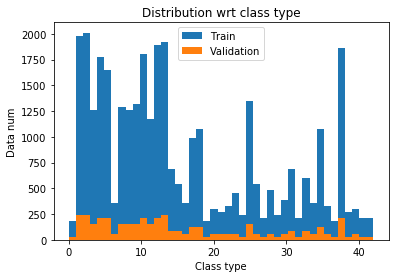

In [4]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
# Show histogram to see data distribution wrt class type
fig = plt.figure()
plt.hist(y_train, bins=n_classes, label='Train')
plt.hist(y_valid, bins=n_classes, label='Validation')
plt.title('Distribution wrt class type')
plt.xlabel('Class type')
plt.ylabel('Data num')
plt.legend()

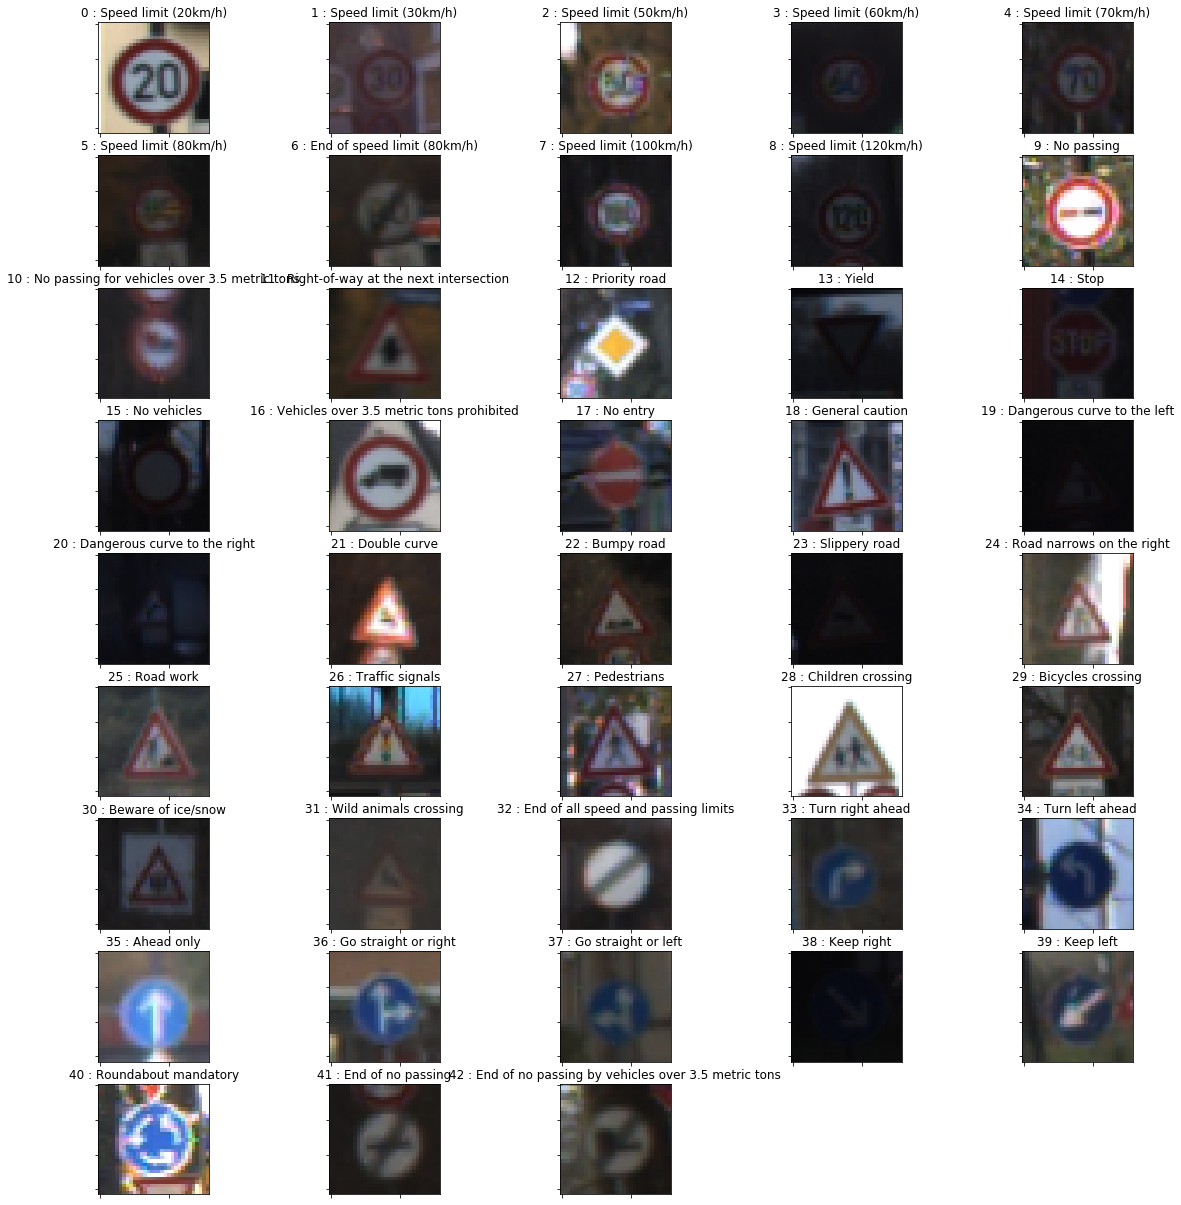

In [5]:
# Show image and sign name in the data set
import csv
with open('signnames.csv', 'r') as f:
    r = csv.reader(f)
    header = next(r)
    sign_names = [row[1] for row in r]

fig = plt.figure(figsize=(20, 24))
plt.title('Sample of train image for each class')
for i in range(n_classes):
    plt.subplot(10, 5, i + 1)
    index = list(y_train).index(i)
    plt.title(str(i) + ' : ' + sign_names[i])
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.imshow(X_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Increase num of training set by Data Augmentation
Num of data set of each class is increased so that every class has the same num of train data.
Newly added data is generated by randomly processed data augmentation technique.

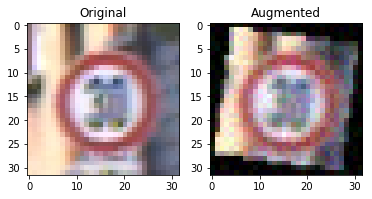

In [6]:
import cv2
import numpy as np
from scipy.ndimage.interpolation import rotate

def rand_crop(img):
    h, w, _ = img.shape
    ratio = np.random.rand() * 0.1
    x_offset = int(w*ratio)
    y_offset = int(h*ratio)
    cropped = img[x_offset:(w-x_offset), y_offset:(h-y_offset), ]
    return cv2.resize(cropped, (h, w))

def rand_rotate(img):
    h, w, _ = img.shape
    angle = np.random.randint(-20, 20)
    img = rotate(img, angle)
    return cv2.resize(img, (h, w))

def rand_noise(img):
    noise = np.random.randint(-20, 20, img.shape).astype(np.int32)
    return np.clip(noise + img.astype(np.int32), 0, 255).astype(np.uint8) 

def augment_img(src):
    # in : RGB (w, h, 3), uint8
    # returns : RGB (w, h, 3), uint8
    out = np.copy(src)
    out = rand_crop(out)
    out = rand_rotate(out)
    out = rand_noise(out)

    return out

def show_augmented_sample():
    sample = X_test[100]
    plt.subplot(121)
    plt.imshow(sample)
    plt.title('Original')
    plt.subplot(122)
    plt.title('Augmented')
    plt.imshow(augment_img(sample))

show_augmented_sample()


In [7]:
INCREASE_FACTOR = 1.5
DO_AUGMENT = True

n_max_train = max(train_num_per_class)
print('Before augmentation: ', train_num_per_class)
X_augmented = []
y_augmented = []
for c in range(n_classes):
    if not DO_AUGMENT:
        break
    n_original = train_num_per_class[c]
    n_augmented = max(0, int(n_max_train * INCREASE_FACTOR) - n_original)
    data_indexes = train_class[c]
    # print('Class {}: original:{} + augmented:{}'.format(c, n_original, n_augmented))

    for i in range(n_augmented):
        src = X_train[data_indexes[i % n_original]]
        X_augmented.append(augment_img(src))
        y_augmented.append(c)

X_train = np.vstack((X_train, np.array(X_augmented))) if X_augmented else X_train
y_train = np.hstack((y_train, np.array(y_augmented))) if y_augmented else y_train
print(len(y_train))

Before augmentation:  [180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]
129645


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
import cv2
import tensorflow as tf
import numpy as np

def preprocess_img_tf(img):
    # TensorFlow processes image
    # in: gray(w,h,1), uint8
    # returns: gray(w,h,1), float32
    # normalize
    img = tf.subtract(tf.image.convert_image_dtype(img, tf.float32), 0.5)
    # Linearly scales image to have zero mean and unit norm.
    img = tf.image.per_image_standardization(img)
    return img

def preprocess_img_cv(img):
    # OpenCV processes image
    # in: RGB(w,h,3), uint8
    # returns: gray(w,h,1), uint8
    w, h, _ = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(img)
    return img.reshape(w, h, 1)

def preprocess_dataset(dataset):
    cv_out = np.array([preprocess_img_cv(img) for img in dataset])

    with tf.Session() as sess:
        x = tf.placeholder(tf.uint8, (None, *cv_out[0].shape))
        out = tf.map_fn(lambda i: preprocess_img_tf(i), x, dtype=tf.float32)
        return sess.run(out, feed_dict={x: cv_out})

# Preprocess train and validate data sets
X_train = preprocess_dataset(X_train)
X_valid = preprocess_dataset(X_valid)

### Model Architecture

In [9]:
from tensorflow.contrib.layers import flatten
# This model is the first version and it's not used right now.
def prev_LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    #fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 120), mean = mu, stddev = sigma))
    #fc2_b  = tf.Variable(tf.zeros(120))
    #fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    #fc2    = tf.nn.relu(fc2)
    
    # Dropout
    #fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [23]:
import tensorflow as tf

# Hyper parameters
EPOCHS = 14
BATCH_SIZE = 128
rate = 0.001
KEEP_PROB = 0.67

In [24]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, *X_train[0].shape))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
#logits = prev_LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# added to anlyze the trend of failure classes
incorrect_prediction_float = tf.cast(tf.logical_not(correct_prediction), tf.float32)
failure_class_hist_op = tf.unsorted_segment_sum(incorrect_prediction_float, tf.argmax(one_hot_y, 1), n_classes)

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_failure_class_hist = np.zeros(n_classes)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, failure_class_hist = sess.run([accuracy_operation, failure_class_hist_op],
                                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_failure_class_hist += failure_class_hist
    return total_accuracy / num_examples, total_failure_class_hist


In [25]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracy_seq = []
    train_accuracy_seq = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        validation_accuracy, validation_failure_class_hist = evaluate(X_valid, y_valid)
        train_accuracy, _ = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Accuracy: Train = {:.3f},   Validation = {:.3f}".format(train_accuracy, validation_accuracy))
        validation_accuracy_seq.append(validation_accuracy)
        train_accuracy_seq.append(train_accuracy)
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Accuracy: Train = 0.875,   Validation = 0.879

EPOCH 2 ...
Accuracy: Train = 0.921,   Validation = 0.927

EPOCH 3 ...
Accuracy: Train = 0.938,   Validation = 0.932

EPOCH 4 ...
Accuracy: Train = 0.942,   Validation = 0.941

EPOCH 5 ...
Accuracy: Train = 0.952,   Validation = 0.953

EPOCH 6 ...
Accuracy: Train = 0.957,   Validation = 0.953

EPOCH 7 ...
Accuracy: Train = 0.958,   Validation = 0.956

EPOCH 8 ...
Accuracy: Train = 0.960,   Validation = 0.958

EPOCH 9 ...
Accuracy: Train = 0.965,   Validation = 0.966

EPOCH 10 ...
Accuracy: Train = 0.963,   Validation = 0.964

EPOCH 11 ...
Accuracy: Train = 0.968,   Validation = 0.964

EPOCH 12 ...
Accuracy: Train = 0.972,   Validation = 0.970

EPOCH 13 ...
Accuracy: Train = 0.970,   Validation = 0.972

EPOCH 14 ...
Accuracy: Train = 0.970,   Validation = 0.968

Model saved


### Visualize accuracy and failure trend wrt class type

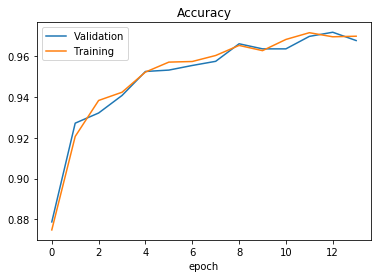

In [26]:
def plot_accuracy():
    plt.figure()
    plt.plot(validation_accuracy_seq, label='Validation')
    plt.plot(train_accuracy_seq, label='Training')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.legend()

def plot_failure_trend():
    plt.figure()
    validation_failure_rate = validation_failure_class_hist / np.bincount(y_valid)
    plt.subplot(211)
    plt.bar(np.arange(n_classes), validation_failure_rate)
    plt.title('failure class trend in training')
    plt.xlabel('class')
    plt.ylabel('Failure rate in validation')

    plt.subplot(212)
    plt.bar(np.arange(n_classes), np.bincount(y_train))
    plt.xlabel('class')
    plt.ylabel('Histogram in tran set')

plot_accuracy()
# plot_failure_trend()
plt.show()

### Test with dataset for testing

In [27]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, _ = evaluate(preprocess_dataset(X_test), y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.935


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Num of new test image is : 5


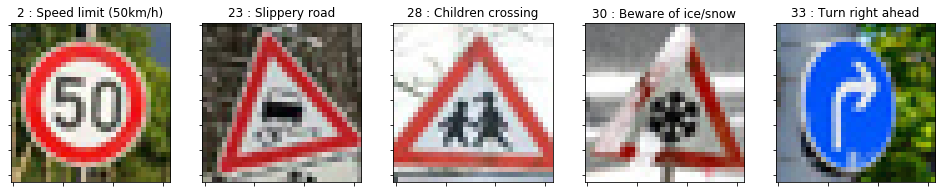

In [45]:
NEW_DATA_DIR_PATH = 'new_test_data_from_web'
import glob
import os
def load_test_data_from_jpg_files(dir_path):
    imgs = []
    labels = []
    for img_path in sorted(glob.glob('{}/*.jpg'.format(dir_path))):
        label = int(os.path.splitext(os.path.basename(img_path))[0])  # ex. folder/5.jpg  => label=5
        labels.append(label)
        imgs.append(plt.imread(img_path))
    return np.array(imgs), np.array(labels)
        
n_newtest = len(glob.glob('{}/*.jpg'.format(NEW_DATA_DIR_PATH)))
print('Num of new test image is : {}'.format(n_newtest))
X_newtest, y_newtest = load_test_data_from_jpg_files(NEW_DATA_DIR_PATH)

# Plot image
fig = plt.figure(figsize=(20, 6))
for i in range(n_newtest):
    plt.subplot((n_newtest + 6 - 1) // 6, 6, i + 1)
    label = y_newtest[i]
    plt.title('{} : {}'.format(label, sign_names[label]))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.imshow(X_newtest[i])

### Predict the Sign Type for Each Image

In [46]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
newtest_correctness = np.zeros_like(n_newtest)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    _x, _y = preprocess_dataset(X_newtest), y_newtest
    newtest_correctness = sess.run(correct_prediction, feed_dict={x: _x, y: _y, keep_prob: 1.0})

### Analyze Performance

In [47]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print(newtest_correctness)
newtest_performance = np.sum(newtest_correctness == True) / n_newtest
print('Performance = {}%'.format(newtest_performance * 100))

[ True  True  True False  True]
Performance = 80.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [48]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
top5_prob_op = tf.nn.top_k(tf.nn.softmax(logits), k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    _x, _y = preprocess_dataset(X_newtest), y_newtest
    top5_prob = sess.run(top5_prob_op, feed_dict={x: _x, y: _y, keep_prob: 1.0})
    print(top5_prob)

TopKV2(values=array([[  7.37125456e-01,   1.72738254e-01,   5.32603562e-02,
          2.67769415e-02,   4.93546156e-03],
       [  9.99862313e-01,   5.77914725e-05,   4.79500341e-05,
          1.65142628e-05,   1.05043846e-05],
       [  8.35576892e-01,   9.18418020e-02,   3.00273988e-02,
          2.14150716e-02,   6.52453071e-03],
       [  9.03168857e-01,   6.17065877e-02,   2.33836658e-02,
          8.86996556e-03,   1.01675850e-03],
       [  9.98594105e-01,   1.04102527e-03,   1.68109764e-04,
          4.26823972e-05,   2.83310765e-05]], dtype=float32), indices=array([[ 2,  5,  1,  3,  7],
       [23, 20, 19, 16, 10],
       [28, 29, 20, 35, 30],
       [12, 40, 11, 42,  3],
       [33, 35,  3, 39, 25]], dtype=int32))


In [50]:
# Generate str for write up
def generate_str_for_writeup():
    for i in range(5):
        out = 'For the {0}th image, the model is relatively sure that this is a "{1}" sign (probability of {2:.3f}),' \
            'and the image does contain a {1} sign. The top five soft max probabilities were:\n' \
            .format(i, sign_names[y_newtest[i]], top5_prob[0][i][0])
        print(out)
        graph = '| Probability         	|     Prediction	       				|\n' \
                '|:---------------------:|:---------------------------------------------:|\n'
        for j in range(5):
            graph += '| .{:.0f}         			| {}   		|\n' \
            .format(top5_prob[0][i][j] * 100, sign_names[top5_prob[1][i][j]])
        print(graph)

# generate_str_for_writeup()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")